https://learnopencv.com/variational-autoencoder-in-tensorflow/

In [1]:
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import numpy as np

import matplotlib.pyplot as plt

from IPython import display

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.astype('float32')

In [4]:
# x_train = x_train / 255. # normalized later
x_test = x_test / 255.

Batch and shuffle the data

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)

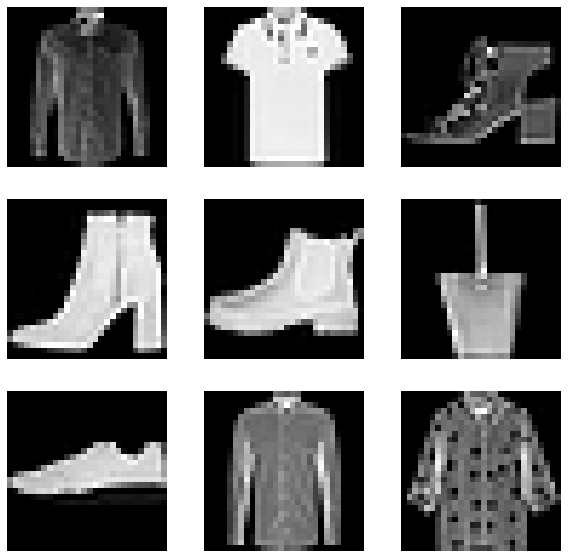

In [6]:
plt.figure(figsize=(10,10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i, :, :, 0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale=1./255)

In [8]:
normalized_ds = train_dataset.map(lambda x: normalization_layer(x))

In [9]:
image_batch = next(iter(normalized_ds))

In [10]:
first_image = image_batch[0]

In [11]:
input_encoder = (28, 28, 1)
input_decoder = (2,)

In [12]:
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0.0, stddev=1.0)
    print(epsilon)
    return mean + K.exp(log_var / 2) * epsilon

In [13]:
sampling_model

<function __main__.sampling_model>

In [14]:
def encoder(input_encoder):
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    flatten = layers.Flatten()(x)
    mean = layers.Dense(2, name='mean')(flatten)
    log_var = layers.Dense(2, name='log_var')(flatten)
    
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

In [15]:
enc = encoder(input_encoder)
# enc.save

In [16]:
enc.output

(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'mean')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'log_var')>)

In [17]:
input_1 = (2,)
input_2 = (2,)

In [18]:
def sampling(input_1, input_2):
    mean = keras.Input(shape=input_1, name="input_layer1")
    log_var = keras.Input(shape=input_2, name="input_layer2")
    out = layers.Lambda(sampling_model, name="encoder_output")([mean, log_var])
    enc_2 = tf.keras.Model([mean, log_var], out, name="Encoder_2")
    return enc_2

In [19]:
final = sampling(input_1, input_2)
# final.save

Tensor("encoder_output/random_normal:0", shape=(None, 2), dtype=float32)


In [20]:
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs) # Check values
    x = tf.reshape(x, [-1, 7, 7, 64], name='Reshape_Layer') # Check values
    
    # Block 1
    x = layers.Conv2DTranspose(64, 3, strides=1, padding='same', name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    # Block 2
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block 3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block 4
    outputs = layers.Conv2DTranspose(1, 3, 1, padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    
    model = tf.keras.Model(inputs, outputs, name="Decoder")    
    return model

In [21]:
dec = decoder(input_decoder)
# dec.save

Optimizer and Loss Function

In [22]:
optimizer = tf.keras.optimizers.Adam(lr=5e-4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis=[1,2,3])
    return 1000 * r_loss

In [24]:
def kl_loss(mean, log_var):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss

In [25]:
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl__loss = kl_loss(mean, log_var)
    return r_loss + kl__loss

In [26]:
# Notice the use ot 'tf.function'
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = enc(images, training=True)
        latent = final([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    
    return loss

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_images([enc, final, dec], epoch + 1, seed)
        # enc.save_weights
        # dec.save_weights
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec')
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_images([enc, final, dec], epochs, seed)

In [28]:
def generate_images(model, epoch, test_input):
    # Training is set to 'False' so all layers run in inference mode (batchnorm)
    m, v = enc(test_input, training=False)
    latent = final([m, v])
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, 1+i)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")
        
    # plt.savefig
    plt.show()

tf.Tensor(
[[-0.11131696 -0.17082673]
 [ 0.61468583  1.2643352 ]
 [ 0.41647044  0.7726054 ]
 [-0.08125854  1.3161244 ]
 [ 0.5380778  -0.14230728]
 [-1.1873891  -1.1210107 ]
 [ 2.9510455   1.9355228 ]
 [ 1.331434    0.60795206]
 [-0.45959774 -0.33316368]
 [ 1.3734821   1.2400461 ]
 [-0.40859228  0.4311542 ]
 [-2.2339272   2.426495  ]
 [ 0.20463572  1.0609994 ]
 [ 0.08408813 -0.8270555 ]
 [-0.02047514 -0.46985668]
 [ 1.6053443   0.8079043 ]
 [ 1.8545188   0.45528042]
 [ 0.9881061   0.45205328]
 [ 0.5300955  -0.6676779 ]
 [-0.6003354   0.28985158]
 [ 0.5763535   1.7214001 ]
 [-0.08488773  0.43251356]
 [ 0.27986136  0.55531466]
 [-0.9941187   1.4588935 ]
 [ 1.0295315  -0.27479845]], shape=(25, 2), dtype=float32)
(25, 28, 28, 1)


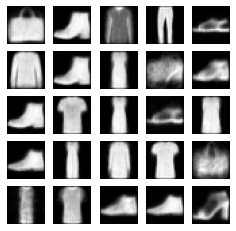

In [29]:
train(normalized_ds, 100)

Visualize the Latent Space

In [30]:
imgs_vizualize = 5000
figsize = 10

In [31]:
index = np.random.choice(range(len(x_test)), imgs_vizualize)
images = x_test[index]

In [32]:
m, v = enc.predict(images)
embeddings = final([m, v])

tf.Tensor(
[[ 9.0980619e-01 -2.6832917e-01]
 [ 1.2064924e+00  5.5913246e-01]
 [ 7.3124033e-01 -1.8475838e-01]
 ...
 [ 2.5585270e-04  6.6846561e-01]
 [ 5.2329439e-01  6.8096077e-01]
 [ 3.8169456e-01 -4.8756006e-01]], shape=(5000, 2), dtype=float32)


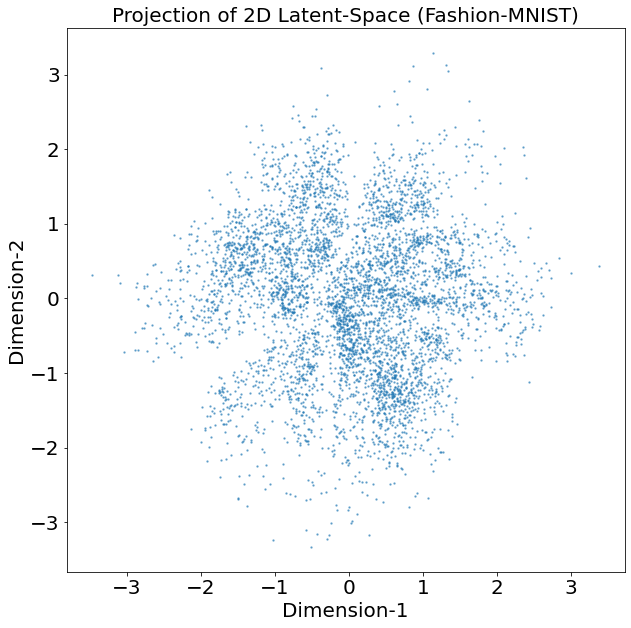

In [33]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space (Fashion-MNIST)", size=20)
plt.show()

Reconstructing Fashion Images with Latent-Vector Sampled Uniformly

In [34]:
min_x = min(embeddings[:, 0])
max_x = max(embeddings[:, 0])
min_y = min(embeddings[:, 1])
max_y = max(embeddings[:, 1])

In [35]:
x = np.random.uniform(low=min_x,high=max_x, size = (10,1))
y = np.random.uniform(low=min_y,high=max_y, size = (10,1))

In [36]:
bottleneck = np.concatenate((x, y), axis=1)

In [37]:
reconst = dec.predict(bottleneck)

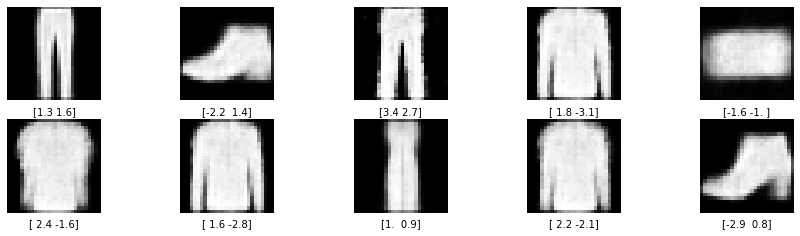

In [38]:
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(np.round(bottleneck[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

In [39]:
colors = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan',
}

In [40]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Reconstructing Test Images

tf.Tensor(
[[-1.3255911  -0.21874838]
 [ 0.27518746 -2.3982174 ]
 [ 0.7650733  -0.4080219 ]
 [-1.2918496  -0.56257904]
 [-0.64714116  1.5731341 ]
 [-1.1666698   0.6829355 ]
 [ 0.36077017  0.7949845 ]
 [-0.17703047  1.4484767 ]
 [ 0.61295825 -0.18374653]
 [-1.3709904  -0.36721137]
 [-0.2315726   0.3616706 ]
 [ 2.182325   -1.4245042 ]
 [-0.76109594 -0.21218596]
 [ 1.1692685  -0.21370882]
 [ 0.9035294   0.10824906]
 [-0.5363033  -0.16776334]
 [-0.3901651  -1.1578157 ]
 [-1.3290191  -1.212425  ]
 [ 1.7715161   1.5735677 ]
 [ 1.0722214  -0.5154484 ]
 [ 1.2734857  -0.09311803]
 [ 0.60365504 -1.1796294 ]
 [-1.0579275   2.4487073 ]
 [-1.1854018   0.05685845]
 [ 0.6129664  -0.43381506]], shape=(25, 2), dtype=float32)


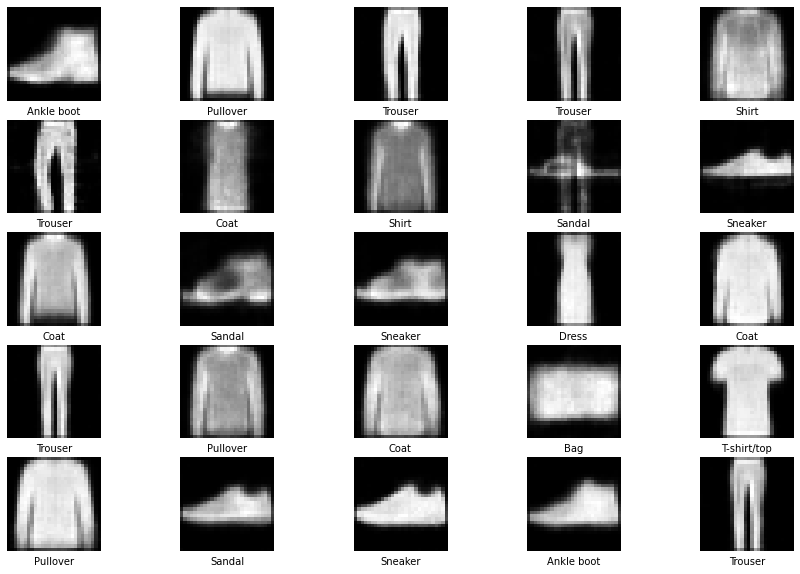

In [41]:
figsize = 15

m, v = enc.predict(x_test[:25])
latent = final([m,v])
reconst = dec.predict(latent)

fig = plt.figure(figsize=(figsize, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str(label_dict[y_test[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0]*255, cmap = 'gray')

Reconstructing Fashion Images with Latent-Vector Sampled from Normal Distribution

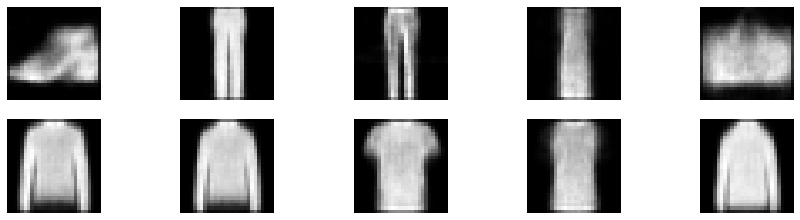

In [42]:
figsize = 15

x = np.random.normal(size = (10,2))
#x = np.random.uniform(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow(reconstruct[i, :,:,0]*255, cmap = 'gray')